<a href="https://colab.research.google.com/github/OlumidePhilip/MscProjectimplementation-code/blob/main/Siamese_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siemese Networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.core.lambda_layer import Lambda
import cv2

In [2]:
tf.__version__

'2.12.0'

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d stoicstatic/face-recognition-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
!unzip -q face-recognition-dataset.zip

unzip:  cannot find or open face-recognition-dataset.zip, face-recognition-dataset.zip.zip or face-recognition-dataset.zip.ZIP.


In [7]:
BS = 8
EPOCHS = 100
IMG_HEIGHT = 64
IMG_WIDTH = 64
target_shape = (IMG_HEIGHT, IMG_WIDTH)

## Preprocess data

In [8]:
faces_path = 'Extracted Faces/Extracted Faces'

In [9]:
list_ds = tf.data.Dataset.list_files(faces_path+ "/*/*", shuffle=False)

InvalidArgumentError: ignored

In [10]:
def load_image(filename, bw = True):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    label = tf.strings.split(filename, os.path.sep)[2]
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    #image = tf.image.convert_image_dtype(image, tf.float32)
    if bw == True:
      image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, target_shape)
    image = image / 225
    return image, label

In [11]:
dataset = np.zeros((len(list_ds), target_shape[0], target_shape[1], 1))
labels = np.zeros(len(list_ds))
for i, d in enumerate(list_ds.map(load_image).as_numpy_iterator()):
  dataset[i] = d[0]
  labels[i] = d[1]

NameError: ignored

In [ ]:
dataset.shape

(6107, 64, 64, 1)

In [ ]:
def create_pairs(dataset, labels):
  pair_images = []
  pair_labels = []
  for la in np.unique(labels):
    inds = np.where(labels == la)[0]
    imgOne = dataset[inds[0]]
    #plt.imshow(imgOne)
    imgTwo = dataset[np.random.choice(inds[1:])]
    #plt.imshow(imgTwo)
    if (imgOne == imgTwo).all():
      print('here')
    pair_images.append((imgOne, imgTwo))
    pair_labels.append(1)

    neg_inds = np.where(labels != la)[0]
    negImgTwo = dataset[np.random.choice(neg_inds)]
    pair_images.append((imgOne, negImgTwo))
    pair_labels.append(0)

  return np.array(pair_images), np.array(pair_labels).astype("float32")


In [ ]:
paired_images , paired_labels = create_pairs(dataset, labels)

In [ ]:
paired_images.shape

(2648, 2, 64, 64, 1)

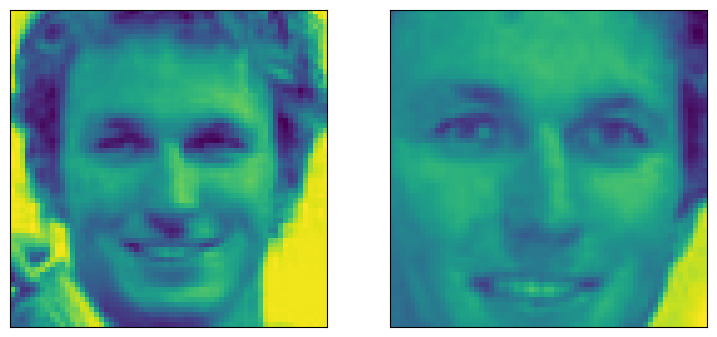

In [ ]:
def show_images(img1, img2):
    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(1,2)
    axs[0].imshow(img1)
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)

    axs[1].imshow(img2)
    axs[1].get_xaxis().set_visible(False)
    axs[1].get_yaxis().set_visible(False)


show_images(*paired_images[0])

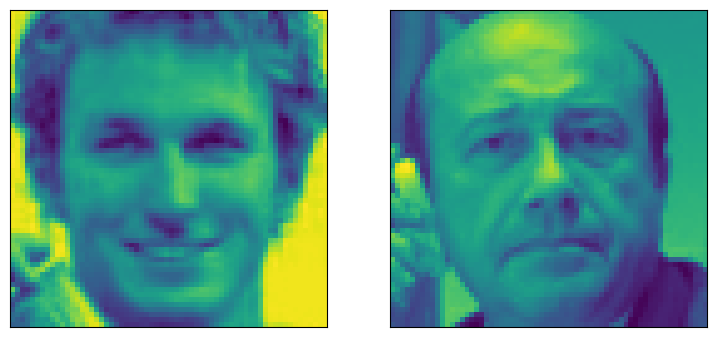

In [ ]:
show_images(*paired_images[1])

# Defining Models

# Siamese Double Net

In [ ]:
def create_model():
  network = tf.keras.Sequential([
        tf.keras.layers.Conv2D(96, (11, 11), activation='relu', padding = "same", input_shape=((IMG_WIDTH, IMG_HEIGHT, 1))),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        tf.keras.layers.Conv2D(256, (5, 5), activation='relu', padding = "same"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding = "same"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(1024),
        tf.keras.layers.Dense(128)
    ])

  def distance_layer(vector_in):
    (base_img, scnd_img) = vector_in
    ss = tf.reduce_sum(tf.square(base_img - scnd_img), axis = 1, keepdims=True)
    return tf.math.maximum(tf.sqrt(ss), tf.keras.backend.epsilon())

  base_img_input = tf.keras.layers.Input(shape=(IMG_WIDTH,IMG_HEIGHT, 1))
  scnd_img_input = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

  processed_inputs = Lambda(distance_layer)(
    [network(base_img_input),
    network(scnd_img_input)]
  )
  output = layers.Dense(1, activation = "sigmoid")(processed_inputs)
  f_network = tf.keras.models.Model(inputs=[base_img_input, scnd_img_input], outputs=output)
  return f_network

In [ ]:
f_network = create_model()

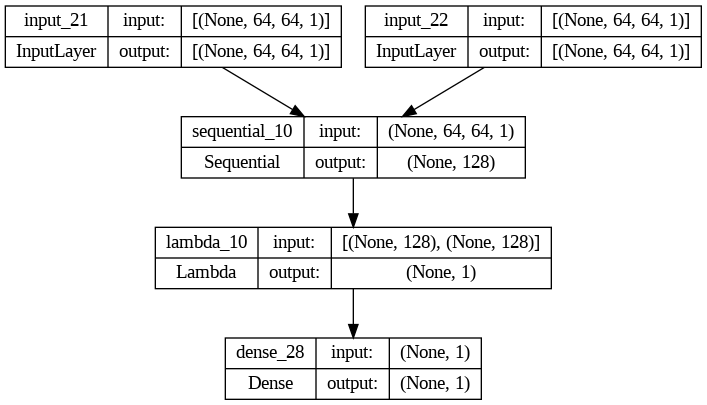

In [ ]:
tf.keras.utils.plot_model(f_network, show_shapes= True, to_file = "full_model.png")

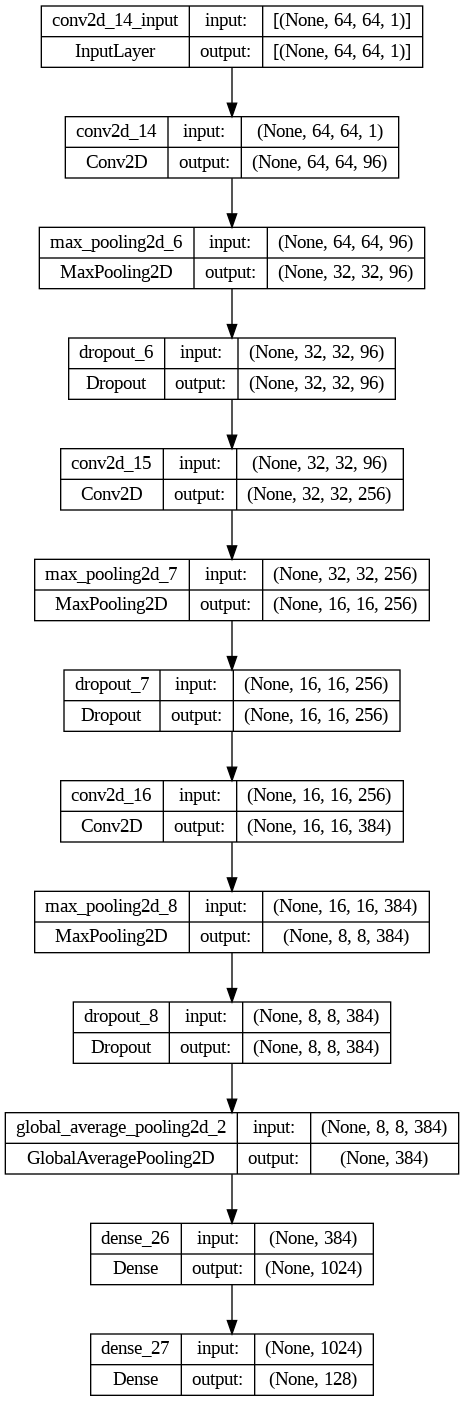

In [ ]:
tf.keras.utils.plot_model(f_network.get_layer('sequential_10'), show_shapes= True, to_file = "siamese_net.png")

In [ ]:
f_network.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
h = f_network.fit([paired_images[:2000, 0], paired_images[:2000, 1]], paired_labels[:2000], validation_data = ([paired_images[2000:, 0], paired_images[2000:, 1]], paired_labels[2000:]), batch_size=64, epochs = EPOCHS, shuffle = True)

Epoch 1/100
32/32 [==============================] - 10s 134ms/step - loss: 0.6948 - accuracy: 0.5005 - val_loss: 0.6928 - val_accuracy: 0.5525
Epoch 2/100
32/32 [==============================] - 3s 103ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6921 - val_accuracy: 0.5571
Epoch 3/100
32/32 [==============================] - 3s 105ms/step - loss: 0.6956 - accuracy: 0.5120 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 3s 105ms/step - loss: 0.6922 - accuracy: 0.5195 - val_loss: 0.6909 - val_accuracy: 0.5309
Epoch 5/100
32/32 [==============================] - 3s 105ms/step - loss: 0.6888 - accuracy: 0.5330 - val_loss: 0.6883 - val_accuracy: 0.5324
Epoch 6/100
32/32 [==============================] - 3s 103ms/step - loss: 0.6889 - accuracy: 0.5365 - val_loss: 0.6828 - val_accuracy: 0.5262
Epoch 7/100
32/32 [==============================] - 3s 106ms/step - loss: 0.6895 - accuracy: 0.5270 - val_loss: 0.6852 - val_accuracy: 0.604

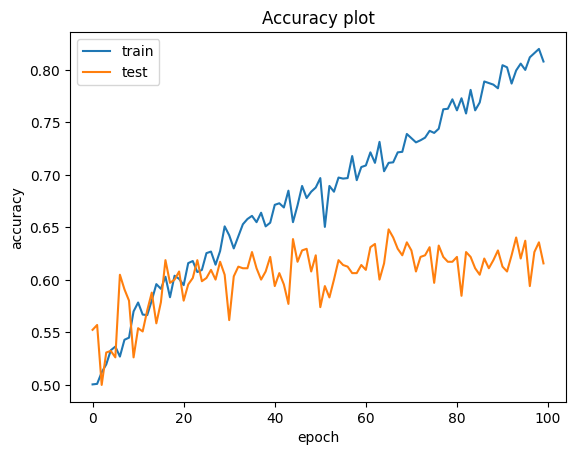

In [ ]:
hist = h.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("model_accuracy.png")

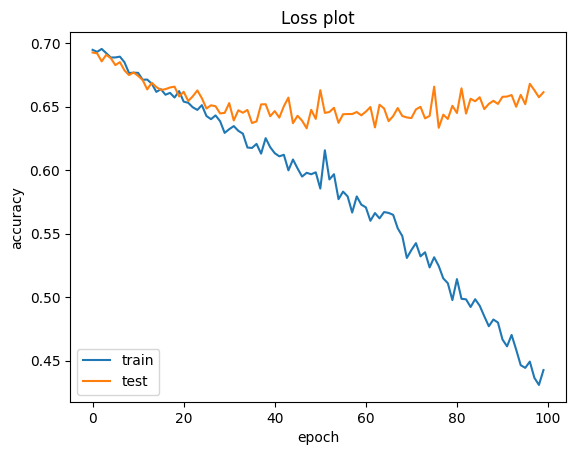

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Loss plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("model_loss.png")

In [ ]:
def test_pred(n = '', bsImg = '', scImg = ''):
  if n != '':
    img1 = np.expand_dims(paired_images[n][0], axis = 0)
    img2 = np.expand_dims(paired_images[n][1], axis = 0)
    p = f_network.predict([img1, img2])[0][0]
    if n % 2 == 0:
      if round(p, 2) > 0.5:
        print("Similar", "Correct")
      else:
        print("Not Similar", "Wrong")
    else:
      if round(p, 2) < 0.5:
        print("Not similar", "Correct")
      else:
        print("Similar", "Wrong")
    show_images(*paired_images[n])
  else:
    bsImgE = np.expand_dims(np.expand_dims(bsImg, axis = -1), axis = 0)
    scImgE = np.expand_dims(np.expand_dims(scImg, axis = -1), axis = 0)
    p = f_network.predict([bsImgE, scImgE])[0][0]
    print(p)
    if round(p, 2) > 0.5:
        print("Similar")
    else:
      print("Not Similar")
    show_images(bsImg, scImg)

1/1 [==============================] - 0s 401ms/step
Similar Correct


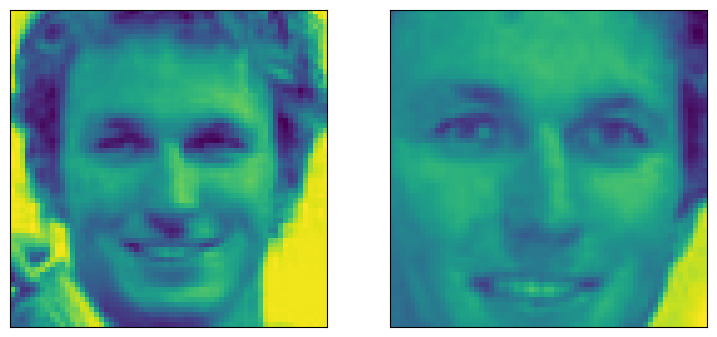

In [ ]:
test_pred(0)

1/1 [==============================] - 0s 30ms/step
Not similar Correct


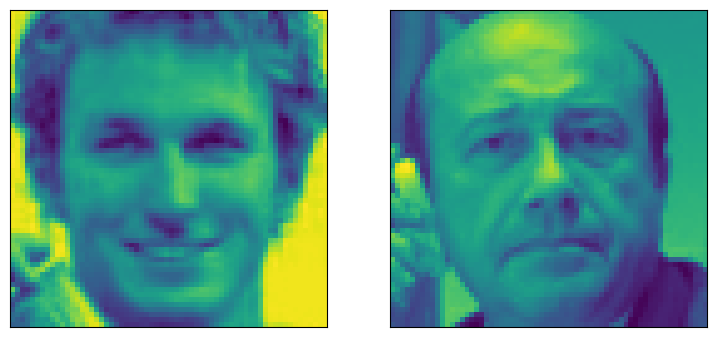

In [ ]:
test_pred(1)

1/1 [==============================] - 0s 19ms/step
Similar Correct


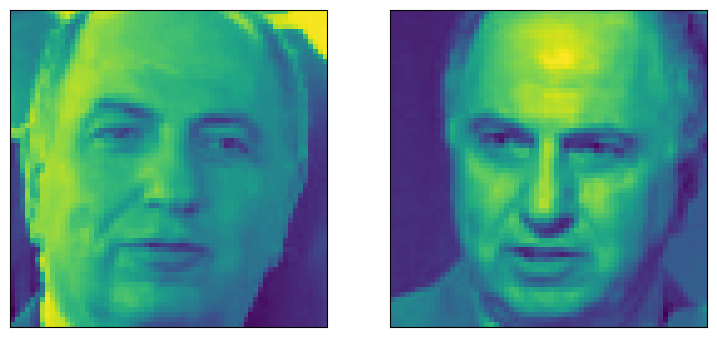

In [ ]:
test_pred(22)

1/1 [==============================] - 0s 21ms/step
Not similar Correct


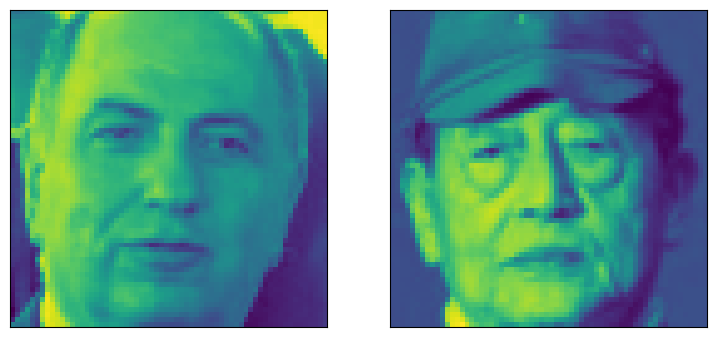

In [ ]:
test_pred(23)

1/1 [==============================] - 0s 20ms/step
Similar Wrong


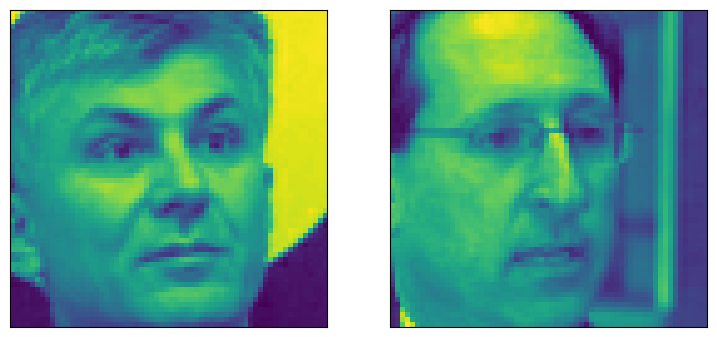

In [ ]:
test_pred(-1)

1/1 [==============================] - 0s 24ms/step
Similar Correct


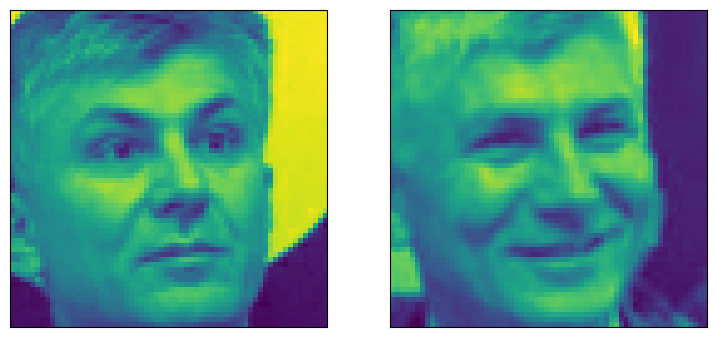

In [ ]:
test_pred(-2)

In [ ]:
f_network.save('drive/MyDrive/Mol/final_model.h5')

In [ ]:
f_network.save_weights("drive/MyDrive/Mol/f_model_weights.h5")

In [ ]:
# serialize model to JSON
model_json = f_network.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model_json = f_network.to_json()
with open("drive/MyDrive/Mol/final_model_conf.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import load_model
f_network = load_model('drive/MyDrive/Mol/f_model.h5')

In [ ]:
p1 = "https://vignette4.wikia.nocookie.net/althistory/images/f/f0/Kingchaz3.jpg/"
p2 = "https://cdn.images.express.co.uk/img/dynamic/106/285x395/1045346_1.jpg"
p3 = "https://i.pinimg.com/736x/5f/23/3e/5f233e4d961d07ab765ede9dadf62fcb--prince-charles-cambridge.jpg"
p4 = "https://pyxis.nymag.com/v1/imgs/dec/970/81245a2b4368ace8e61988cedea6a204d6-30-Elon-Musk.rsquare.w200.jpg"

In [ ]:
!wget -O imgBase.jpg "https://cdn.britannica.com/59/235359-050-910E0798/Prince-Charles-Prince-of-Wales-The-Guiness-Partnerships-Pondbury-Dorset-Dorchester-England-2015.jpg?w=290&h=340&c=crop"

--2023-08-28 09:26:14--  https://cdn.britannica.com/59/235359-050-910E0798/Prince-Charles-Prince-of-Wales-The-Guiness-Partnerships-Pondbury-Dorset-Dorchester-England-2015.jpg?w=290&h=340&c=crop
Resolving cdn.britannica.com (cdn.britannica.com)... 18.164.154.6, 18.164.154.38, 18.164.154.124, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|18.164.154.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19875 (19K) [image/jpeg]
Saving to: ‘imgBase.jpg’

imgBase.jpg         100%[===================>]  19.41K  --.-KB/s    in 0s      

2023-08-28 09:26:15 (188 MB/s) - ‘imgBase.jpg’ saved [19875/19875]



In [ ]:
!wget -O simImg.jpg "https://iv1.lisimg.com/image/5696888/410full-prince-charles.jpg"

--2023-08-28 09:26:17--  https://iv1.lisimg.com/image/5696888/410full-prince-charles.jpg
Resolving iv1.lisimg.com (iv1.lisimg.com)... 169.150.249.166, 2400:52e0:1a01::994:1
Connecting to iv1.lisimg.com (iv1.lisimg.com)|169.150.249.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39187 (38K) [image/jpeg]
Saving to: ‘simImg.jpg’

simImg.jpg          100%[===================>]  38.27K  --.-KB/s    in 0.01s   

2023-08-28 09:26:18 (3.41 MB/s) - ‘simImg.jpg’ saved [39187/39187]



In [ ]:
!wget -O simImg2.jpg "https://vignette4.wikia.nocookie.net/althistory/images/f/f0/Kingchaz3.jpg/"

--2023-08-28 09:26:19--  https://vignette4.wikia.nocookie.net/althistory/images/f/f0/Kingchaz3.jpg/
Resolving vignette4.wikia.nocookie.net (vignette4.wikia.nocookie.net)... 74.120.184.204, 74.120.184.194
Connecting to vignette4.wikia.nocookie.net (vignette4.wikia.nocookie.net)|74.120.184.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29332 (29K) [image/jpeg]
Saving to: ‘simImg2.jpg’

simImg2.jpg         100%[===================>]  28.64K  --.-KB/s    in 0.01s   

2023-08-28 09:26:20 (1.93 MB/s) - ‘simImg2.jpg’ saved [29332/29332]



In [ ]:
!wget -O negImg.jpg "https://pyxis.nymag.com/v1/imgs/dec/970/81245a2b4368ace8e61988cedea6a204d6-30-Elon-Musk.rsquare.w200.jpg"

--2023-08-28 09:26:26--  https://pyxis.nymag.com/v1/imgs/dec/970/81245a2b4368ace8e61988cedea6a204d6-30-Elon-Musk.rsquare.w200.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.133, 151.101.66.133, 151.101.130.133, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8185 (8.0K) [image/jpeg]
Saving to: ‘negImg.jpg’

negImg.jpg          100%[===================>]   7.99K  --.-KB/s    in 0s      

2023-08-28 09:26:26 (80.9 MB/s) - ‘negImg.jpg’ saved [8185/8185]



In [ ]:
def crop_out_face(img, T = True, name = ''):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    face = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if len(face) >= 1:
        print('here')
        print(len(face))
        for (x, y, w, h) in face:
            face_roi = img[y:y + h, x:x + w]
        if T == True:
            cv2.imwrite(name, face_roi)
        return face_roi
    else:
        return "no-img"

In [ ]:
bs_img = cv2.imread("imgBase.jpg", cv2.IMREAD_GRAYSCALE)
bs_img = crop_out_face(bs_img, True, "cropped.jpg")
bs_img = cv2.resize(bs_img, target_shape)
bs_img = bs_img / 225

here
1


In [ ]:
sim_img = cv2.imread("simImg.jpg", cv2.IMREAD_GRAYSCALE)
sim_img = crop_out_face(sim_img, False)
sim_img= cv2.resize(sim_img, target_shape)
sim_img = sim_img/255

here
1


In [ ]:
sim_img2 = cv2.imread("simImg2.jpg", cv2.IMREAD_GRAYSCALE)
sim_img2 = crop_out_face(sim_img2, False)
sim_img2= cv2.resize(sim_img2, target_shape)
sim_img2 = sim_img2/255

here
1


In [ ]:
negImg = cv2.imread("negImg.jpg", cv2.IMREAD_GRAYSCALE)
negImg = crop_out_face(negImg, False)
negImg= cv2.resize(negImg, target_shape)
negImg = negImg/255

here
1


1/1 [==============================] - 0s 80ms/step
0.75471693
Similar


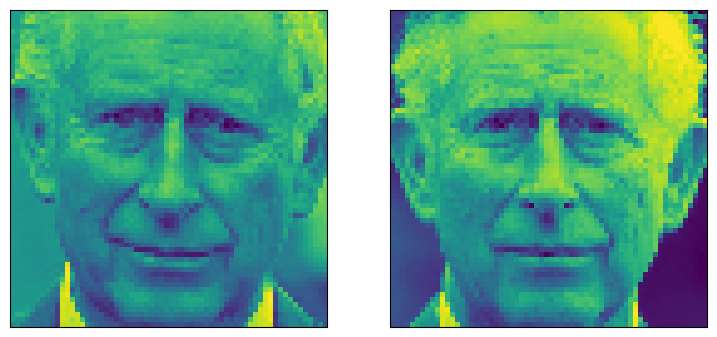

In [ ]:
test_pred(bsImg=bs_img, scImg=sim_img)

1/1 [==============================] - 0s 63ms/step
0.47557864
Not Similar


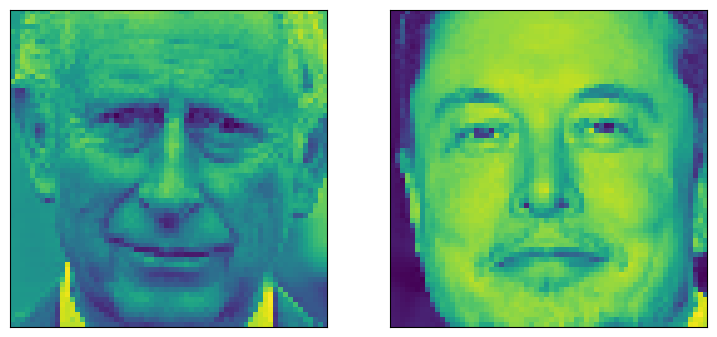

In [ ]:
test_pred(bsImg=bs_img, scImg=negImg)

1/1 [==============================] - 0s 73ms/step
0.8196905
Similar


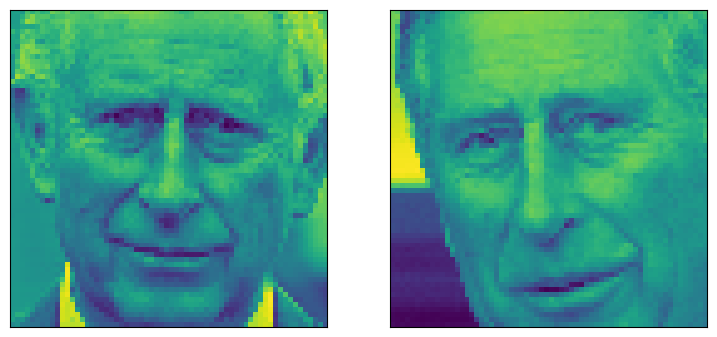

In [ ]:
test_pred(bsImg=bs_img, scImg=sim_img2)

# Histogram methhod

here
1
here
1
Similarity:  29581.0


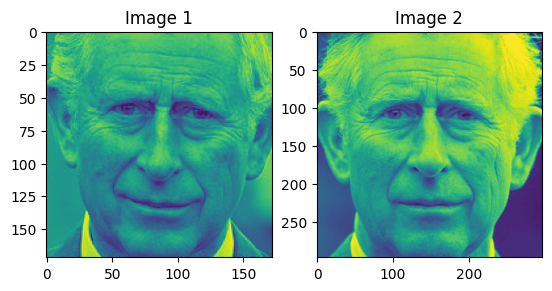

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calculate_histogram(image):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    return histogram

# Load the two images
image1 = cv2.imread('imgBase.jpg')
bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.imread('simImg.jpg')
bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


im1 = cropped_bw1 = crop_out_face(bw1, False, "crp0.jpg")
im2 = cropped_bw2 = crop_out_face(bw2, False, "crp1.jpg")

# Calculate histograms for the two images
histogram1 = calculate_histogram(im1)
histogram2 = calculate_histogram(im2)

# Compare the histograms
similarity = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)

# Print the similarity score
print("Similarity: ", similarity)

# Display the images
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title('Image 2')

plt.show()


here
1
here
1
Similarity:  28944.0


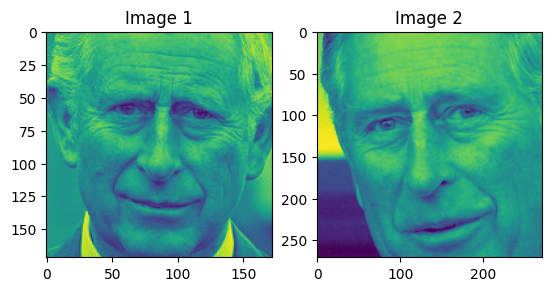

In [ ]:
# Load the two images
image1 = cv2.imread('imgBase.jpg')
bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.imread('simImg2.jpg')
bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


im1 = cropped_bw1 = crop_out_face(bw1, False, "crp0.jpg")
im2 = cropped_bw2 = crop_out_face(bw2, False, "crp1.jpg")

# Calculate histograms for the two images
histogram1 = calculate_histogram(im1)
histogram2 = calculate_histogram(im2)

# Compare the histograms
similarity = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)

# Print the similarity score
print("Similarity: ", similarity)

# Display the images
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title('Image 2')

plt.show()

here
1
here
1
Similarity:  13429.0


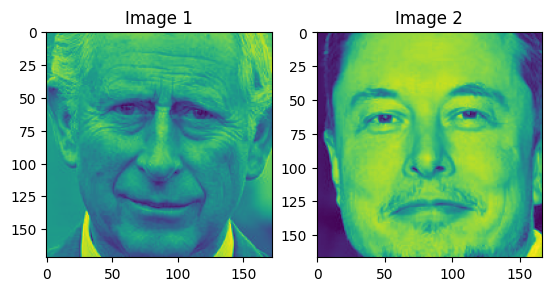

In [ ]:
# Load the two images
image1 = cv2.imread('imgBase.jpg')
bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.imread('negImg.jpg')
bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


im1 = cropped_bw1 = crop_out_face(bw1, False, "crp0.jpg")
im2 = cropped_bw2 = crop_out_face(bw2, False, "crp1.jpg")

# Calculate histograms for the two images
histogram1 = calculate_histogram(im1)
histogram2 = calculate_histogram(im2)

# Compare the histograms
similarity = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)

# Print the similarity score
print("Similarity: ", similarity)

# Display the images
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title('Image 2')

plt.show()

# SIFT method

here
1
here
1
163
91.7496566772461 113.66617584228516 453.49090576171875


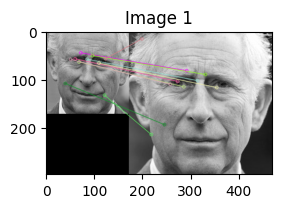

In [ ]:

image1 = cv2.imread('imgBase.jpg')
bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.imread('simImg.jpg')
bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


im1 = cropped_bw1 = crop_out_face(bw1, False, "crp0.jpg")
im2 = cropped_bw2 = crop_out_face(bw2, False, "crp1.jpg")
# Create a SIFT object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance
print(len(matches))
matches = sorted(matches, key=lambda x: x.distance)
print(matches[0].distance,matches[1].distance, matches[-1].distance)


# Draw the top N matches
N = 10
matched_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.show()


here
1
here
1
163
182.96994018554688 204.5311737060547 465.1128845214844


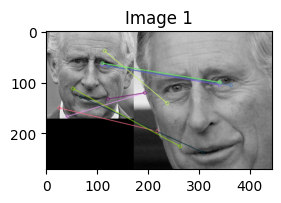

In [ ]:

image1 = cv2.imread('imgBase.jpg')
bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.imread('simImg2.jpg')
bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


im1 = cropped_bw1 = crop_out_face(bw1, False, "crp0.jpg")
im2 = cropped_bw2 = crop_out_face(bw2, False, "crp1.jpg")
# Create a SIFT object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance
print(len(matches))
matches = sorted(matches, key=lambda x: x.distance)
print(matches[0].distance,matches[1].distance, matches[-1].distance)


# Draw the top N matches
N = 10
matched_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image
#cv2.imshow("Matches", matched_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.show()


here
1
here
1
163
196.21926879882812 213.7475128173828 484.6617431640625


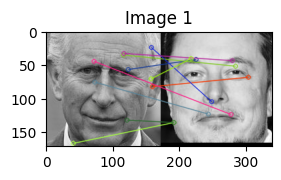

In [ ]:

image1 = cv2.imread('imgBase.jpg')
bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.imread('negImg.jpg')
bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


im1 = cropped_bw1 = crop_out_face(bw1, False, "crp0.jpg")
im2 = cropped_bw2 = crop_out_face(bw2, False, "crp1.jpg")
# Create a SIFT object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance
print(len(matches))
matches = sorted(matches, key=lambda x: x.distance)
print(matches[0].distance, matches[1].distance, matches[-1].distance)


# Draw the top N matches
N = 10
matched_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image
#cv2.imshow("Matches", matched_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.show()


# SURF

In [ ]:
image1 = cv2.imread('/content/Screenshot 2023-06-13 005527.png')
image2 = cv2.imread('/content/Screenshot 2023-06-13 005543.png')

# Create a SURF object
surf = cv2.xfeatures2d.SURF_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = surf.detectAndCompute(image1, None)
keypoints2, descriptors2 = surf.detectAndCompute(image2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match the descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

if matches[0].distance > 100:
  print('Same')
else:
  print('Different')

# Draw the top N matches
N = 10
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image
#cv2.imshow("Matches", matched_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.show()

error: ignored

# ORB

Same


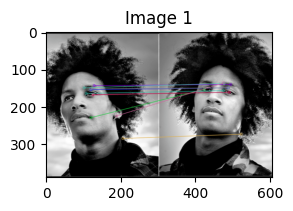

In [ ]:
import cv2

# Load the images
image1 = cv2.imread('/content/Screenshot 2023-06-13 005527.png')
image2 = cv2.imread('/content/Screenshot 2023-06-13 005543.png')

# Create an ORB object
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

if matches[0].distance > 10:
  print('Same')
else:
  print('Different')

# Draw the top N matches
N = 10
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image
#cv2.imshow("Matches", matched_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.show()
